In [1]:
# make a comparison of just the different blood groups
# Single Var pred : Only Blood Type and no other features-
# Pick the 5 and 10 best features and 

In [2]:
import pandas as pd
import numpy as np
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve 

from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.svm import SVC

from sklearn.model_selection import KFold, cross_val_score

import copy
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
blacklist = ['Risk_Factor_NONE',' Incubation period (days)']

TierOneFeature = ['Age', ' Incubation period (days)', 'Cyanosis', 'Risk_Factor_AT', 'Risk_Factor_COPD', 'Risk_Factor_DM', 'Risk_Factor_DMHT', 'Risk_Factor_HT', 'Risk_Factor_NONE']
TierTwoFeature = ['Sore_throat', 'Diarrhea', 'CONTROL_blood_group_B+', 'Risk_Factor_AP']
TierThreeFeature = ['CONTROL_blood_group_AB+', 'Risk_Factor_CA', 'Headache', 'Risk_Factor_ARF', 'Risk_Factor_CKD', 'Risk_Factor_COPDDM', 'CONTROL_blood_group_O+', 'Cough']

coreFeatures = TierOneFeature

In [4]:
unneeded_data = ['Place_of_isolation','Patient_In','Patient_out']
catigorical_data=['Blood_Group','CONTROL_blood_group','Risk_Factor']
labels = ['Severeity','Outcome']
droped_col = unneeded_data+catigorical_data+labels

In [5]:
df = pd.read_csv("Covid-19_dataset.csv",header=1)


df['is_Male'] = pd.get_dummies(df['Gender'])['MALE']#one hot encoding gender so male = #1 and female = 0

blood_types = pd.get_dummies(df['Blood_Group']).columns
blood_group_columns = pd.get_dummies(df[['Blood_Group','CONTROL_blood_group']]).columns


df = pd.concat([df, pd.get_dummies(df[['Blood_Group','CONTROL_blood_group','Risk_Factor','Infection_type']])], axis=1)



df = df.drop(['Blood_Group','CONTROL_blood_group','Risk_Factor','Infection_type','Gender','Place_of_isolation','Patient_In','Patient_out'],axis=1)

columns = df.columns



# getting rid of blank values
print("before",df.shape)
for name in columns:
    df = df[df[name] != " "]
    df = df.dropna()
    
label_Severeity = df['Severeity'] #Severeity vs Outcome
label_Outcome = df['Outcome']
df = df.drop(['Severeity','Outcome'],axis=1)


df = df.applymap(lambda x: pd.to_numeric(x, errors='coerce'))#strings to numeric
all_columns = df.columns
# df = df.reset_index()

print("after",df.shape)





before (5668, 57)
after (5641, 55)


In [6]:
blood_type_labels =[]
control_blood_type_labels = []
for i in blood_group_columns:
    if("CONTROL_" in i):
        control_blood_type_labels.append(i)
    else:
        blood_type_labels.append(i)

In [7]:
usedFeatures = ['is_Male'] + coreFeatures

In [8]:
df_gender_data = df[usedFeatures]
df_gender_data

,is_Male,Age,Incubation period (days),Cyanosis,Risk_Factor_AT,Risk_Factor_COPD,Risk_Factor_DM,Risk_Factor_DMHT,Risk_Factor_HT,Risk_Factor_NONE
0,1,61.0,14,0,0,0,0,0,0,1
1,1,49.0,28,0,0,0,0,0,0,1
2,1,88.0,1,1,0,1,0,0,0,0
3,1,56.0,17,0,0,0,0,0,0,1
4,1,41.0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
5663,1,65.0,14,0,0,0,0,0,0,1
5664,1,32.0,7,1,0,0,0,0,0,0
5665,1,28.0,4,1,0,0,0,0,0,0
5666,1,40.0,1,1,0,0,0,0,0,0


In [9]:
df_gender_data

,is_Male,Age,Incubation period (days),Cyanosis,Risk_Factor_AT,Risk_Factor_COPD,Risk_Factor_DM,Risk_Factor_DMHT,Risk_Factor_HT,Risk_Factor_NONE
0,1,61.0,14,0,0,0,0,0,0,1
1,1,49.0,28,0,0,0,0,0,0,1
2,1,88.0,1,1,0,1,0,0,0,0
3,1,56.0,17,0,0,0,0,0,0,1
4,1,41.0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
5663,1,65.0,14,0,0,0,0,0,0,1
5664,1,32.0,7,1,0,0,0,0,0,0
5665,1,28.0,4,1,0,0,0,0,0,0
5666,1,40.0,1,1,0,0,0,0,0,0


In [10]:
df_gender_data['is_Male']

0       1
1       1
2       1
3       1
4       1
       ..
5663    1
5664    1
5665    1
5666    1
5667    1
Name: is_Male, Length: 5641, dtype: int64

In [11]:
df=df.drop(blacklist,axis=1)

In [12]:
def AUCBloodTypeComparison(model,K=10):
    plt.subplot(2, 1, 1)
    plt.figure(figsize=(10,6))

    
    %matplotlib inline

    for isMale in [0,1]:
        all_features = df[df['is_Male']== isMale]
        y = label_Outcome[df['is_Male']== isMale]

        
        

        # Training ONLY on the training set to get AUC:
        tempModel = copy.deepcopy(model)
        model.fit(all_features, y)
        predict = model.predict(all_features)
        prob = model.predict_proba(all_features)
        fpr, tpr, thresholds = metrics.roc_curve(y, prob[:,1], pos_label='Recovered')
        AUC = metrics.auc(fpr, tpr)
        if(isMale == 0):
            plt.plot(fpr, tpr,label=f"Female AUC: {AUC}")
        else:
            plt.plot(fpr, tpr,label=f"Male AUC: {AUC}")
            
    plt.figlegend(loc='center right')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('All Features ROC Curve')
    plt.show()
    
    plt.subplot(2, 1, 2)
    plt.figure(figsize=(10,6))

    
    %matplotlib inline

    for isMale in [0,1]:
        all_features = df_gender_data[df_gender_data['is_Male']== isMale]
        y = label_Outcome[df_gender_data['is_Male']== isMale]

        
        

        # Training ONLY on the training set to get AUC:
        tempModel = copy.deepcopy(model)
        model.fit(all_features, y)
        predict = model.predict(all_features)
        prob = model.predict_proba(all_features)
        fpr, tpr, thresholds = metrics.roc_curve(y, prob[:,1], pos_label='Recovered')
        AUC = metrics.auc(fpr, tpr)
        if(isMale == 0):
            plt.plot(fpr, tpr,label=f"Female AUC: {AUC}")
        else:
            plt.plot(fpr, tpr,label=f"Male AUC: {AUC}")


    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Tier 1 ROC Curve')
    plt.figlegend(loc='center right')
    plt.tight_layout()
    plt.show()


Ada Boost Classifier


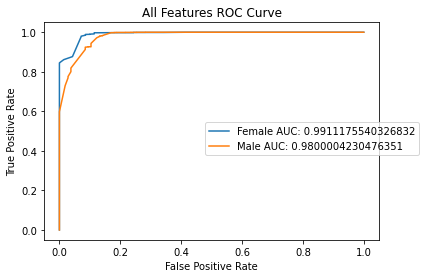

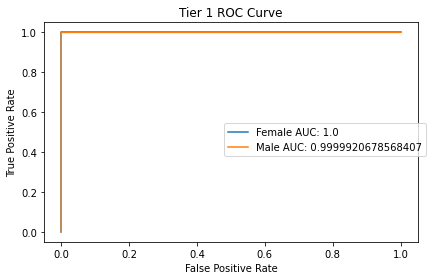

In [13]:
print("Ada Boost Classifier")
my_AdaBoost = AdaBoostClassifier(n_estimators=14, random_state=4)
AUCBloodTypeComparison(my_AdaBoost)

Logistic Regression


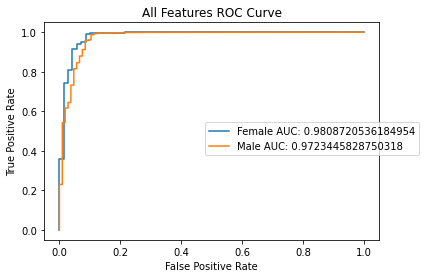

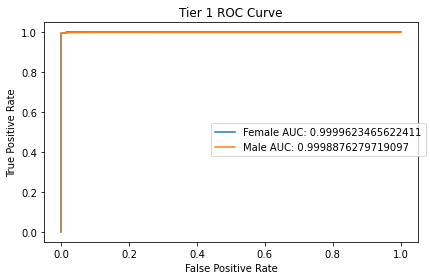

In [14]:
print("Logistic Regression")
my_logreg = LogisticRegression(max_iter=10000)
AUCBloodTypeComparison(my_logreg)

Decision Tree


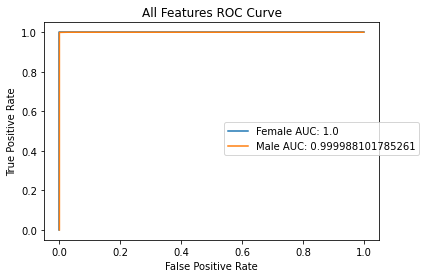

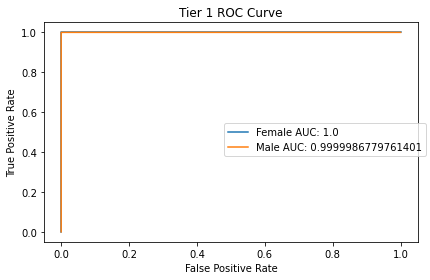

In [15]:
print("Decision Tree")
my_DecisionTree = DecisionTreeClassifier(random_state=4)
AUCBloodTypeComparison(my_DecisionTree)

Random Forest Classifier


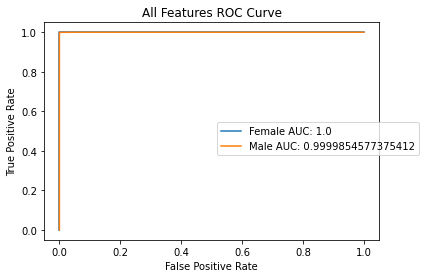

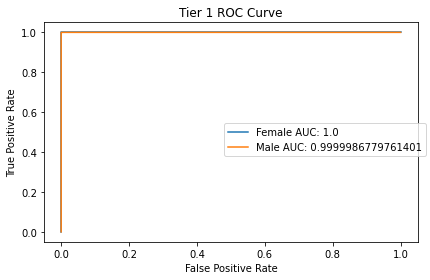

In [16]:
print("Random Forest Classifier")
my_RandomForest = RandomForestClassifier(n_estimators=29, bootstrap=True, random_state=4)
AUCBloodTypeComparison(my_RandomForest)

SVM


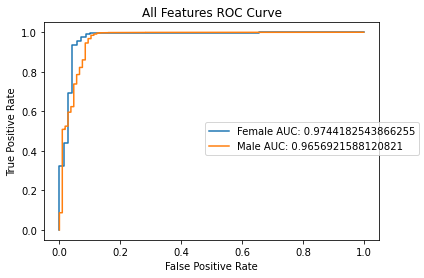

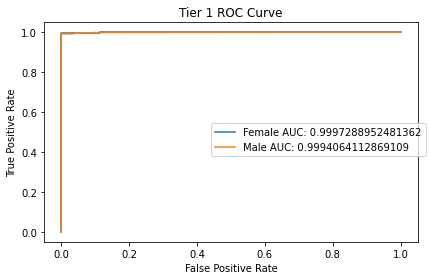

In [17]:
print("SVM")
my_svm = SVC(kernel='rbf', probability=True)
AUCBloodTypeComparison(my_svm)